## Tarea 4 - Inteligencia Artificial


### Andrés Jimenez Mora - Moisés Salguero Morales

## Importación de librerías

Lo primero que se realiza es instalar las librerías en caso de que se trabaje con Jupyter Notebook, luego se importan como se muestra a continuación. Las librerías más importantes son Pygad y Control que son las librerías que se usan para generar el sistema genético y además, para trabajar los sistemas de control automático respectivamente.

In [2]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import control as co
from itertools import groupby
from queue import Queue
import random 

## Definición del sistema de control 

El sistema de control que se propuso resolver es el que se observa en la siguiente imagen. En el código se definen los valores algebráicos de cada uno de los factores que pertenecen a dicho sistema y además, el sistema como tal. Lo que se busca con este trabajo es generar un algoritmo genético que resuelva el sistema de tal manera que el sistema sea estable y además, que a un tiempo de 1 segundo el sobreimpulso sea de no más de 20%.

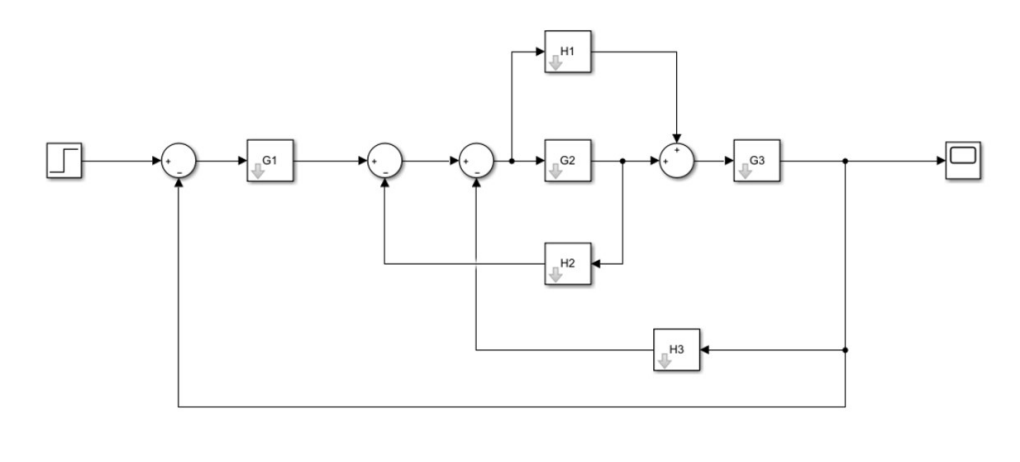

## Correspondencia Genotipo-Fenotipo 

Para el contexto de este problema, nuestro genotipo se define como un conjunto de 15 variables (genes) que pueden tener valores en un rango definido. La combinación de estos 15 genes dan como resultado un sistema con un comportamiento específico (fenotipo), se busca que sea un sistema estable, subamortiguado y con un sobreimpulso del 20%. En las siguientes líneas de código se define el sistema y su respuesta para un conjunto dado de variables/genes.

In [3]:
def control_system(parametros_sys):
    #Constantes del sistema
    A1, B1, C1, A2, B2, C2, D2, A3, B3, C3, K1, F1, K2, F2, K3=parametros_sys 
    
    #Se define cada función de transferencia individualemente
    G1 = co.tf([A1], [B1, B1*C1, 0])
    G2 = co.tf([A2, 0], [B2, 0, B2*C2+D2])
    G3 = co.tf([A3, A3*C3, 0], [B3])
    H1 = co.tf([K1*F1, K1], [1])
    H2 = co.tf([K2*F2, K2, 0], [1])
    H3 = co.tf([K3, 0], [1])
    
    #Se define el sistema completo
    sys=(G1*G3*(G2+H1))/(1+H1*G2+(G2+H1)*G3*H3+G1*G3*(G2+H1))
    
    return sys

### Ejemplo de prueba
Se ha realizado un ejemplo de prueba para observar la forma de la función de transferencia del sistema planteado. A continuación se observa de una manera más gráfica. 

In [4]:
#Ejemplo de prueba
control_system([0.1, 2, 1.5, 1, 0.5, 0.8, 2, 1.05, 0.45, 1, 2, 1.5, 1.4, 1, 2.45])

TransferFunction(array([7.97343750e-03, 2.52492188e-02, 1.83654844e-01, 5.06047500e-01,
       1.67155144e+00, 3.83490450e+00, 7.49987910e+00, 1.31902344e+01,
       1.65410683e+01, 1.84001933e+01, 1.42851341e+01, 4.23263232e+00,
       0.00000000e+00, 0.00000000e+00]), array([3.90698438e-01, 1.82325938e+00, 1.08549049e+01, 3.83029320e+01,
       1.19285230e+02, 3.11522537e+02, 6.52903484e+02, 1.20796848e+03,
       1.80577603e+03, 2.17192024e+03, 2.13800945e+03, 1.37372958e+03,
       4.28512032e+02, 7.32396557e+01, 3.14424115e+01, 0.00000000e+00,
       0.00000000e+00]))

### Respuesta del sistema ante un escalón unitario y su sobreimpulso a 1s. 

Acá se definió una función que retorna el sobreimpulso del sistema a 1 segundo. Y además, calcula la respuesta ante un escalón.

In [5]:
#Respuesta del sistema a un escalón unitario y sobre impulso
def step_response(system):
    
    #Respuesta al escalón unitario a modo de prueba
    t=np.linspace(0, 100,100)
    t1,y1=co.step_response(system,t)

    plt.plot(t1,y1)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    
    pos_t=t1.tolist()
    pos_t=[int(x) for x in pos_t]
    index=pos_t.index(1.0)
    SobreImp=((y1[index]-y1[-1])/y1[-1])*100 #cálculo del sobreimpulso en porcentaj
    
    
    return SobreImp

### Ejemplo de prueba.

Ejemplo de prueba de la respuesta del sistema ante una entrada escalón.

-2.1178757132372104


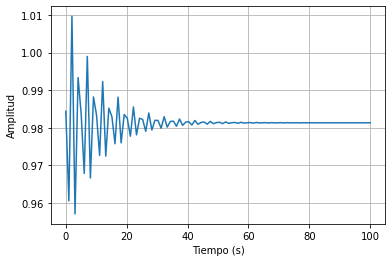

In [6]:
#Ejemplo de prueba
sys = control_system([1, 1, 6, 5, 7, 6, 1, 9, 1, 5, 7, 0, 0, 0, 0])
print(step_response(sys))

### Función de estabilidad

La función de estabilidad que se definió evalúa si el sistema es estable o no. Y además que tan "estable es", es decir, se realiza un conteo de la cantidad de polos que existen a la derecha del eje imaginario; los polos que poseen parte real positiva. Esta variable de la cantidad de polos en el eje real positivo se usará para evaluar la calidad de las soluciones en la función de calidad. En resumen, si existen polos con parte real positiva el sistema se toma como intestable, y se cuenta la cantidad de ellos que existan. De lo contrario el sistema será estable.

In [7]:
# función de estabilidad

def stability(system): 
    estable=True           #como parámetro inicial se define al sistema estable 
    polos=co.pole(system)  # numero de polos del sistema
    positivos= 0           # cantidad de polos en eje real
    sumPolos=0
    
    for i in range(0,len(polos)):
        num=polos[i]
        
        if (num.real>0.0001):
            sumPolos=sumPolos+num.real
            positivos +=1   # si el polo es positivo suma 1 al # de polos positivos 
            estable=False
            
    if (estable==False): 
        sumPolos=sumPolos/positivos
    
    return estable, positivos, sumPolos # retorna la estabilidad y el # de polos positivos 

## Ejemplo de prueba de estabilidad 

A continuación se genera una prueba de la estabilidad de un sistema, esto con el fin de comprobar si la mejor solución que devuelva el algoritmo generico es realmente estable y no tiene polos en el eje real positivo. 

In [8]:
#Ejemplo de prueba de estabilidad
sys=control_system([0.1, 2, 1.5, 1, 0.5, 0.8, 2, 1.05, 0.45, 1, 2, 1.5, 1.4, 1, 2.45])
Est, posit, sumPolos = stability(sys)
print ("Estabilidad del sistema: " + str(Est))
print ("Número de polos en el eje real: " + str(posit))
print ("Promedio de polos positivos: " + str(sumPolos))

Estabilidad del sistema: False
Número de polos en el eje real: 2
Promedio de polos positivos: 0.050313434973478496


## Definición de la función de calidad 

La función de calidad es uno de los elementos más importantes del algoritmo genético, ya qué esta evalúa que tanto se acerca la solución propuesta a lo que se busca, es decir, si la solución propuesta resuelve el problema de manera tal que su resultado es el esperado. En este caso la función de calidad evalúa dos cosas principalmente: la estabilidad del sistema y el sobreimpulso. Con respecto a la estabilidad del sistema, si las soluciones propuestas dan como resultado un sistema inestable se le aplica un "castigo" a la calidad, y además se define un sobreimpulso muy pequeño, con el fin de que al calcular la calidad esta sea muy pequeña. En este caso el castigo es afectado por la cantidad de polos con parte real positiva. Si en cambio el sistema es estable el castigo se define como 1 y no afecta la calidad, esta será afectada por qué tan cerca esté el sobreimpulso a 20, que es a lo que se quiere llegar.

In [9]:
global sobreimpulso

def fitness_func(solutions_array, solutions__array_idx):
    try: 
        
        fit=0    # calidad de la respuesta
        system=control_system(solutions_array)  # llamada a control system
        estabilidad, positivos, promPolos =stability(system)           # evaluación de estabilidad

        if (estabilidad==True):
            t=np.linspace(0, 50, 500)
            t1,y1=co.step_response(system,t)
            pos_t=t1.tolist()
            pos_t=[int(x) for x in pos_t]
            index=pos_t.index(1.0)
            SobreImp=(np.abs(1.2-y1[index])/1.2)*100 #cálculo del sobreimpulso en porcentaje
            castigo=1
            
            
        else:
            SobreImp=0.1
            castigo=promPolos*10000*positivos
            print("Y1[-1]: "+ str(y1[-1]))
        
        #print(co.pole(system))
        #print("Castigo: "+str(castigo))
        #print("Y1[10]: "+ str(y1[10]))
        print("Y1[-1]: "+ str(y1[-1]))
        print("Sobre Imp: " +str(SobreImp))
        sobreimpulso=SobreImp
        
        fit=1/(castigo*(np.abs(SobreImp-20.0)+0.000001))
        
    except: 
        fit=0.0000001
        print("error...")
    
    
    return fit


Acá se realiza un ejemplo de prueba para la función de calidad. 

In [10]:
#Ejemplo de prueba
print(fitness_func([1, 1, 6, 5, 7, 6, 1, 9, 1, 5, 7, 0, 1, 0, 0],0))

Y1[-1]: 0.9816014960004474
Sobre Imp: 19.998081164272246
520.8778988450932


## Definición de parámetros del modelo genético

Los parametros del modelo genético son otro elemento muy importante ya que estos afectan en gran manera el resultado que puede devolver el algoritmo genético. Un ejemplo de esto es la exploración y explotación, que son mutuamente excluyentes y dependen de la cantidad de población inicial que se tenga. La exploración se da cuando existe una población inicial grande, lo cual permite explorar una gran cantidad de soluciones; mientras la explotación es un proceso en el que hay una población inical pequeña y se fuerza al algoritmo a encontrar una solución rápida. Para nuestro caso específico se determinó que una población inicial de 200 (pequeña) es adecuada ya que el espacio de alelos no es demasiado grande como para tener una gran variedad de soluciones posibles. Adicionalmente, se definió una población inicial semi-direccionada, es decir 25% definida y 75% random con base en numerosas pruebas. El espacio de alelos se escogió de 1-10 con base en prueba y error a través de númerosas pruebas, se excluyeron los números negativos por completo con base en el criterio necesario para determinar inestabilidad en los sistemas (no tener cambios de signo ni ceros en la ecuación característica). Como metodo de cruzamiento se escogió la ruleta por ser el más convencional, así como un porcentaje de cruzamiento de 30% entre padres. También se planteó un número muy alto de mutación (30%) dado que el espacio de alelos es muy reducido y se dieron casos donde los hijos presentaban mejorar mínimas debido a su poca variación, por lo tanto, una mutación alta fue necesaria.

In [11]:
# definición de la población inicial
lista=[[1,1,6,5,7,6,1,9,1,5,7,0,1,0,0] for _ in range(50)]
lista2=[[random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11),random.randint(1,11)] for _ in range(150)]
lista.extend(lista2)

#Se define la función de calidad
fitness_function = fitness_func


sol_per_pop = 200  # población inicial (cromosomas)
num_genes = 15   # numero de genes (cantidad de constantes de la ecuación)

initial_population= lista 

num_generations = 200   # numero de generaciones creadas
num_parents_mating = int(sol_per_pop*0.30) #int(sol_per_pop*0.25)  # Porcentaje de padres para recombinacion (25%)

init_range_low = 1 #límite inferior rango alelos
init_range_high = 10 # limite superior rango alelos

parent_selection_type = "rws"  # el tipo de selección rws es por ruleta
keep_parents =  int(sol_per_pop*0.25)               # cantidad de padres que permanecen en cada generación 

crossover_type = "two_points"

mutation_type = "random"
mutation_percent_genes = 30

fit_queue = Queue(maxsize = 10) # Cola en la que se almacenan ultimos 10 resultados 

### Sección de Callback

El criterio de parada del algoritmo se basa en esperar a que la calidad deje de cambiar, lo que significa que la optimización ha llegado a su límite. Para la implentación se definió una lista de tipo FIFO donde se van almacenando los últimos 20 resultados del fitness, cuando la lista este llena de resultados iguales entre sí, arroja el "stop" al algoritmo genético para terminar la ejecución y mostrar mejor solución alcanzada.

In [12]:
last_fitness =0

def all_equal(iterable): # funcion que revisa si todos los numeros que le entran son iguales
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

def callback_generation(ga_instance): # Función Callback
    global last_fitness
    # acá se imprimen los datos de la generación y el mejor resultado
    
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) #generacion
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1])) #mejor calidad de la generacion
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) #diferencia entre la calidad actual y la anterior
    print("Best solution: " + str(ga_instance.best_solution()[0]))
    last_fitness = ga_instance.best_solution()[1]
    

    if fit_queue.full(): #revision de la cola para averiguar si se cumple la condicion de parada
      fit_queue.get()
      fit_queue.put(last_fitness)
    
      lista = list(fit_queue.queue)
      if all_equal(lista): #revision de que todos los resultados en la lista sean iguales
        print('Las ultimas 10 soluciones son iguales, parando generacion...')
        return 'stop' #senal para que el algoritmo genetico se detenga

    else: #si la cola aun no esta llena
      fit_queue.put(last_fitness) #llenar la cola con el ultimo resultado

## Definición del modelo evolutivo

Se cargan todos los parámetros escogidos en las líneas anteriores para definir el algoritmo genético.

In [13]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       initial_population = initial_population,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation,
                       gene_type=int)

In [16]:
ga_instance.run()

Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.9812915135055564
Sobre Imp: 20.077250906368295
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.9843294136862333
Sobre Imp: 19.459409460615326
error...
error...
error...
Y1[-1]: 0.9845686556984404
Sobre Imp: 19.589882460311365
error...
Y1[-1]: 0.9816890027412281
Sobre Imp: 19.87719299768483
error...
Y1[-1]: 0.0
Sobre Imp: 100.0
error...
Y1[-1]: 0.9769819686083812
Sobre Imp: 20.88735929224278
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.9769819686083812
Sobre Imp: 20.88735929224278
Y1[-1]: 0.9847143344979569
Sobre Imp: 19.38932976744607
error...
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.9792712086461587
Sobre Imp: 20.39060369668073
error...
Y1[-1]: 0.9828514400873364
Sobre Imp: 19.604538549786437
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.9792712086461587
Sobre Imp: 20.39060369668073
Y1[-1]: 0.9786962042783268
Sobre Imp: 19.89349611130549
Y1[-1]: 0.9767709796289064
Sobre Imp: 20.97803176701535
Y1[-1]: 0.9847143344

Y1[-1]: 0.978357182787664
Sobre Imp: 20.457906520788686
Y1[-1]: 0.9792712086461587
Sobre Imp: 20.39060369668073
error...
error...
error...
Y1[-1]: 0.9741060553313621
Sobre Imp: 21.377803296381625
Y1[-1]: 0.9850424062310684
Sobre Imp: 19.124595264712607
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
error...
Y1[-1]: 0.0
Sobre Imp: 100.0
error...
Y1[-1]: 0.9847143344979569
Sobre Imp: 19.38932976744607
error...
Y1[-1]: 0.9741060553313621
Sobre Imp: 21.377803296381625
Generation = 1
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.9845686556984404
Sobre Imp: 19.589882460311365
Y1[-1]: 0.9847143344979569
Sobre Imp: 19.38932976744607
Y1[-1]: 0.9814643777156994
Sobre Imp: 20.249063278547492
error...
Y1[-1]: 0.9769819686083812
Sobre Imp: 20.88735929224278
error...
Y1[-1]: 0.9784535916699714
Sobre Imp: 20.21440750999069
error...
error...
error...
Y1[-1]: 0.9782462033501697
Sobre Imp: 20.291914465933797
Y1[-1]: 0.9784535916699714
Sobre Imp: 20.21440750999069
error...
er

Y1[-1]: 0.9795711780624036
Sobre Imp: 20.02483997624701
error...
error...
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.0
Sobre Imp: 100.0
error...
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.9843440041233317
Sobre Imp: 19.68375164796765
Y1[-1]: 0.0
Sobre Imp: 100.0
error...
Y1[-1]: 0.9768566413291665
Sobre Imp: 21.21195597123669
Y1[-1]: 0.9819184693959871
Sobre Imp: 19.66828995730104
Y1[-1]: 0.978357182787664
Sobre Imp: 20.457906520788686
Y1[-1]: 0.9792712086461587
Sobre Imp: 20.39060369668073
error...
error...
error...
Y1[-1]: 0.9741060553313621
Sobre Imp: 21.377803296381625
Y1[-1]: 0.9850424062310684
Sobre Imp: 19.124595264712607
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
error...
Y1[-1]: 0.0
Sobre Imp: 100.0
error...
Y1[-1]: 0.9847143344979569
Sobre Imp: 19.38932976744607
error...
Y1[-1]: 0.9741060553313621
Sobre Imp: 21.377803296381625
Change     = 0.0
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.984568655

Y1[-1]: 0.9847143344979569
Sobre Imp: 19.38932976744607
Y1[-1]: 0.9812983123418927
Sobre Imp: 20.355058409455378
error...
error...
error...
Y1[-1]: 0.9819184693959871
Sobre Imp: 19.66828995730104
Y1[-1]: 0.9784535916699714
Sobre Imp: 20.21440750999069
Y1[-1]: 0.9812915135055564
Sobre Imp: 20.077250906368295
Y1[-1]: 0.9812915135055564
Sobre Imp: 20.077250906368295
Y1[-1]: 0.9814643777156994
Sobre Imp: 20.249063278547492
error...
error...
Y1[-1]: 0.9850424062310684
Sobre Imp: 19.124595264712607
Y1[-1]: 0.9792712086461587
Sobre Imp: 20.39060369668073
Y1[-1]: 0.9812915135055564
Sobre Imp: 20.077250906368295
error...
error...
Y1[-1]: 0.9817660187506103
Sobre Imp: 20.34869740580303
Y1[-1]: 0.9819184693959871
Sobre Imp: 19.66828995730104
Y1[-1]: 0.9795711780624036
Sobre Imp: 20.02483997624701
error...
error...
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.0
Sobre Imp: 100.0
error...
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.9843440041233317
Sobre Im

Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642
Y1[-1]: 0.9845686556984404
Sobre Imp: 19.589882460311365
Y1[-1]: 0.9847143344979569
Sobre Imp: 19.38932976744607
Y1[-1]: 0.9814643777156994
Sobre Imp: 20.249063278547492
error...
Y1[-1]: 0.9769819686083812
Sobre Imp: 20.88735929224278
error...
Y1[-1]: 0.9784535916699714
Sobre Imp: 20.21440750999069
error...
error...
error...
Y1[-1]: 0.9782462033501697
Sobre Imp: 20.291914465933797
Y1[-1]: 0.9784535916699714
Sobre Imp: 20.21440750999069
error...
error...
error...
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.0
Sobre Imp: 100.0
Y1[-1]: 0.9819184693959871
Sobre Imp: 19.66828995730104
error...
error...
Y1[-1]: 0.9812238648835757
Sobre Imp: 20.91786289316324
Y1[-1]: 0.9789454560008217
Sobre Imp: 21.04096585540213
Y1[-1]: 0.9812915135055564
Sobre Imp: 20.077250906368295
Y1[-1]: 0.9769819686083812
Sobre Imp: 20.88735929224278
Y1[-1]: 0.9792712086461587
Sobre Imp: 20.39060369668073
error...
Y1[-1]: 0.9812215774224204
Sobre Imp: 20.58168992867642

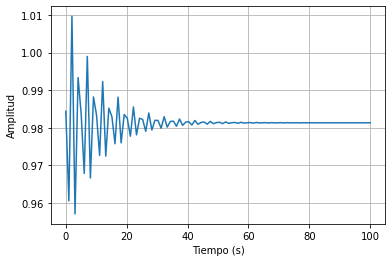

In [18]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parámetros de la mejor solución : {solution}".format(solution=solution))
print("Calidad de la mejor solución = {solution_fitness}".format(solution_fitness=solution_fitness))

print("Predicción sobre el sistema basada en la mejor solución determinada")
predict_sys=control_system(solution);
prediction = step_response(predict_sys)